In [18]:
from mne import create_info, concatenate_raws, Epochs, find_events
from mne.io import RawArray
from matplotlib import pyplot as plt
import json
import os,sys,glob
import numpy as np
import pandas as pd
from IPython.display import clear_output


eegChannels = ['CP3','C3', 'F5', 'PO3', 'PO4', 'F6', 'C4', 'CP4']



def load_data(datadir, seps=[',', ',']):
  od = json.load(open(glob.glob(datadir + '/stimulus_dataset*.json')[0], 'r'))
  df_od = pd.DataFrame(od['trials'])
  df_rawbw = pd.read_csv(glob.glob(datadir + '/rawBrainwaves*.csv')[0],sep=seps[0])
  df_psd = pd.read_csv(glob.glob(datadir + '/psd_*.csv')[0],sep=seps[1])

  return df_od,df_rawbw,df_psd

In [6]:
df_od, df_rawbw, df_psd = load_data("../explorer_datasets/auditory_oddball/fusionDataExport_1705700582/")

In [10]:
df_psd.iloc[0]["CP3"]

'2.384447850291626;2.6927934273083225;1.4431389497829226;1.4365888496193642;3.659941452853733;3.866599926214572;2.237607748399693;0.624098532078712;0.2834923042081659;1.173601111269634;1.9968649154486902;1.8040784495953397;1.8079337693521111;1.5483489568816409;0.7845860962542774;1.4233591997061892;1.8327961562510071;1.2847904491556363;0.5944207339667266;0.24052597136468684;0.4563040722219348;0.43599647178330847;0.2709748411449282;0.06706078300128171;0.22783204817465003;0.0659073253292036;0.22113196670197818;0.11571586130228438;0.17991858761026144;0.09432438556539675;0.176158517921044;0.09158448633259857;0.17209009916489132;0.07921881425788327;0.15024305653147219;0.0904473218372922;0.14785231081185207;0.09406048257987135;0.1530815131002056;0.07339084881736414;0.14059458461986016;0.06966417261956298;0.133823978152568;0.0785956276213851;0.1349002661025087;0.06627936596300624;0.13008205745463156;0.06751162732741438;0.12583806899408764;0.06898261934886404;0.1241729933956891;0.06686535463743

In [47]:
def simple_aob_ana(datadir,thr=1E3, verbose=False, lfreq=1,ufreq=30,
                       standard_stim_str = './assets/sounds/1024hz.mp3', deviant_stim_str = './assets/sounds/1920hz.mp3',
                       doplot1=False,doplot2=False,doplot3=False,doplot4=False,doplot5=False,doplot6=False):

    # Load and clean the data
    df_od,df_rawbw,df_psd = load_data(datadir)


    # Compute power spectra
    all_psds = {}
    for i in df_psd.index:
      for e in eegChannels:
        arow = np.squeeze(pd.DataFrame(np.squeeze(df_psd[e].iloc[i].split(';'))).astype(float).values)
        all_psds[i,e] = pd.DataFrame(arow)[0]
    df_psds_us = pd.DataFrame(all_psds)
    df_psds_us.columns.names = ['trial', 'chan']
    df_psds_us.index.names = ['freq']


    # add a trigger column to the eeg dataframe
    df_rawbw['triggercode'] = 0
    df_rawbw['origtriggertimestamp'] = 0
    df_rawbw['origtriggeridx'] = 0

    # [closestmatch_odidx,closestmatch_eegidx,trigcode]
    matches = [[0,0,0]]
    for i in df_od.index:
      trigcode = 0
      row = df_od.loc[i]
      if row.stimulus == standard_stim_str:
          trigcode = 1
      elif row.stimulus == deviant_stim_str:
          trigcode = 2
      if trigcode>0:
        closestmatch_eegidx = (df_rawbw.unixTimestamp - df_od.loc[i].unixTimestamp).abs().sort_values(ascending=True).index[0]
        closestmatch_odidx = i
        matches.append([closestmatch_odidx,closestmatch_eegidx,trigcode])
    matches = np.array(matches)

    zs1 = np.zeros(df_rawbw.shape[0])
    zs2 = zs1.copy()
    for i,j,k in matches:
      zs1[j] = k
      zs2[j] = i
    df_rawbw['triggercode'] = zs1
    df_rawbw['origtriggeridx'] = zs2



    # Create an MNE object
    # TODO: figure out what's going on here
    #events = np.zeros([matches.shape[0], 3])
    events = np.ones([matches.shape[0], 3]) * np.nan
    events[:,0] = matches[:,1]
    events[:,2] = matches[:,2]

    # also seems to be necessary to get round bug of a bunch of repeated zeros at the top of the matches arr
    events = events[events[:,0] != 0,:]

    events = events.astype(int)


    # this seems to be necessary to get round bug of a bunch of repeated zeros at the top of the matches arr
    matches = matches[matches[:,0] != 0,:]
    #print(matches)


    info = create_info(ch_names= eegChannels + ['stim'], ch_types = ['eeg']*8 + ['stim'], sfreq = 256, verbose=1)
    data = df_rawbw[eegChannels + ['triggercode']].values.T
    raw = RawArray(data=data, info=info, verbose=1)

    # Filtering the data under a certain frequency range
    raw.filter(lfreq,ufreq, method='iir')

    # Compute epoched ddata
    epochs = Epochs(raw,events=events,reject={'eeg': thr})

    # Export epochs to pandas dataframe
    df_epochs = epochs.to_data_frame()
    df_epochs.set_index(['time', 'epoch'],inplace=True)
    df_epochs.columns.names = ['chan']


    orignumstands = df_od[df_od.stimulus==standard_stim_str].shape[0]
    orignumdevs = df_od[df_od.stimulus==deviant_stim_str].shape[0]

    finalnumstands = df_epochs[df_epochs.condition=='1'].shape[0]
    finalnumdevs = df_epochs[df_epochs.condition=='2'].shape[0]

    if verbose==False:
        clear_output()
    else:
        print('orig # standards: %s' %orignumstands)
        print('orig # deviants: %s' %orignumdevs)

        print('final # standards: %s' %finalnumstands)
        print('final # deviants: %s' %finalnumdevs)

    if doplot1:
      fig, ax = plt.subplots(figsize=(18,3),ncols=2)
      df_rawbw.iloc[500:1500][eegChannels].plot(ax=ax[0])
      df_rawbw[eegChannels].drop(['C3','C4'],axis=1).iloc[500:2000].plot(ax=ax[1])


      fig, ax = plt.subplots(ncols=3,nrows=3, figsize=(18,10))
      lastwin = df_psd.index.max()
      slices = sorted(np.random.randint(low=0,high=lastwin,size=9));
      for i_it,i in enumerate(slices):
          a = ax.ravel()[i_it]
          df_psds_us[i].plot(logy=True,ax=a)


    # This one is...
    if doplot2:

        df = df_epochs.copy()
        df = df[df_epochs.condition=='1'][eegChannels]
        df = df.unstack('time').mean(axis=0).unstack('chan')
        df.plot();



    if doplot3:

        fig, ax = plt.subplots(ncols=3, figsize=(18,3))

        df = df_epochs.copy()
        df = df[df_epochs.condition=='1'][eegChannels]
        df = df.unstack('time').mean(axis=0).unstack('chan')
        df.plot(ax=ax[0]);
        ax[0].set_title('Standards')

        df = df_epochs.copy()
        df = df[df_epochs.condition=='2'][eegChannels]
        df = df.unstack('time').mean(axis=0).unstack('chan')
        df.plot(ax=ax[1]);
        ax[1].set_title('Deviants')


        df = df_epochs.copy()
        df = df[eegChannels]
        df = df.unstack('time').mean(axis=0).unstack('chan')
        df.plot(ax=ax[2]);
        ax[2].set_title('All trials')

        plt.tight_layout()



    if doplot4:

        # blue = standard
        # red = deviant
        # green = all trials

        fig, ax = plt.subplots(ncols=4,nrows=2, figsize=(18,6))

        df = df_epochs.copy()[df_epochs.condition=='1'][eegChannels]
        df1m = df.unstack('time').mean(axis=0).unstack('chan').loc[-0.1:0.4]
        df1s = df.unstack('time').sem(axis=0).unstack('chan').loc[-0.1:0.4]

        df = df_epochs.copy()[df_epochs.condition=='2'][eegChannels]
        df2m = df.unstack('time').mean(axis=0).unstack('chan').loc[-0.1:0.4]
        df2s = df.unstack('time').sem(axis=0).unstack('chan').loc[-0.1:0.4]

        df = df_epochs.copy()[eegChannels]
        df3m = df.unstack('time').mean(axis=0).unstack('chan').loc[-0.1:0.4]
        df3s = df.unstack('time').sem(axis=0).unstack('chan').loc[-0.1:0.4]

        for e_it,e in enumerate(sorted(eegChannels)):
          a = ax.ravel()[e_it]
          df1m[e].plot(ax=a, c='b', yerr=df1s[e],alpha=0.2);
          df1m[e].plot(ax=a, c='b',alpha=1);

          df2m[e].plot(ax=a, c='r', yerr=df2s[e],alpha=0.2);
          df2m[e].plot(ax=a, c='r',alpha=1);

          df3m[e].plot(ax=a, c='green', yerr=df3s[e],alpha=0.2);
          df3m[e].plot(ax=a, c='green',alpha=1);
          a.set_title(e)

        plt.tight_layout()



    if doplot5:

        # blue = standard
        # red = deviant
        # green = all trials

        fig, ax = plt.subplots(ncols=4,nrows=2, figsize=(18,6))

        df = df_epochs.copy()[df_epochs.condition=='1'][eegChannels]
        df1m = df.unstack('time').mean(axis=0).unstack('chan').loc[-0.05:0.5]
        df1s = df.unstack('time').sem(axis=0).unstack('chan').loc[-0.05:0.5]

        df = df_epochs.copy()[df_epochs.condition=='2'][eegChannels]
        df2m = df.unstack('time').mean(axis=0).unstack('chan').loc[-0.05:0.5]
        df2s = df.unstack('time').sem(axis=0).unstack('chan').loc[-0.05:0.5]

        df = df_epochs.copy()[eegChannels]
        df3m = df.unstack('time').mean(axis=0).unstack('chan').loc[-0.05:0.5]
        df3s = df.unstack('time').sem(axis=0).unstack('chan').loc[-0.05:0.5]

        for e_it,e in enumerate(sorted(eegChannels)):
          a = ax.ravel()[e_it]
          df1m[e].plot(ax=a, c='b', yerr=df1s[e],alpha=0.2);
          df1m[e].plot(ax=a, c='b',alpha=1,linewidth=3);

          df2m[e].plot(ax=a, c='r', yerr=df2s[e],alpha=0.2);
          df2m[e].plot(ax=a, c='r',alpha=1,linewidth=3);

          df3m[e].plot(ax=a, c='green', yerr=df3s[e],alpha=0.2);
          df3m[e].plot(ax=a, c='green',alpha=1,linewidth=3);
          a.set_title(e)

        plt.tight_layout()



    if doplot6:


        fig, ax = plt.subplots(ncols=2, figsize=(12,3))

        a = ax[0]
        df = df_epochs.copy()[df_epochs.condition=='1'][eegChannels]
        df = df.abs().mean(axis=1).unstack('time').T.loc[-0.01:0.35].T
        df.mean(axis=0).plot(ax=a,c='b',yerr=df.sem(axis=0),alpha=0.1)
        df.mean(axis=0).plot(ax=a,c='b',linewidth=3)

        df = df_epochs.copy()[df_epochs.condition=='2'][eegChannels]
        df = df.abs().mean(axis=1).unstack('time').T.loc[-0.01:0.35].T
        df.mean(axis=0).plot(ax=a,c='r',yerr=df.sem(axis=0),alpha=0.1)
        df.mean(axis=0).plot(ax=a,c='r',linewidth=3)


        a = ax[1]
        df = df_epochs.copy()[df_epochs.condition=='1'][eegChannels]
        df = df.abs().mean(axis=1).unstack('time').T.loc[-0.1:].T
        df.mean(axis=0).plot(ax=a,c='b',yerr=df.sem(axis=0),alpha=0.1)
        df.mean(axis=0).plot(ax=a,c='b',linewidth=3)

        df = df_epochs.copy()[df_epochs.condition=='2'][eegChannels]
        df = df.abs().mean(axis=1).unstack('time').T.loc[-0.1:].T
        df.mean(axis=0).plot(ax=a,c='r',yerr=df.sem(axis=0),alpha=0.1)
        df.mean(axis=0).plot(ax=a,c='r',linewidth=3)



    return df_rawbw,raw,epochs,df_epochs,events,df_psds_us

Creating RawArray with float64 data, n_channels=9, n_times=60240
    Range : 0 ... 60239 =      0.000 ...   235.309 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 30.00 Hz: -6.02, -6.02 dB

Not setting metadata
179 matching events found
Setting baseline interval to [-0.19921875, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 179 events and 180 original time points ...
    Rejecting  epoch based on EEG : ['PO3']
    Rejecting  epoch based on EEG : ['PO3', 'C4']
2 bad epochs dropped


<ipython-input-47-6b3d4eba4baa>:60: RuntimeWarning: invalid value encountered in cast
  events = events.astype(int)


chan            condition           CP3            C3            F5  \
time      epoch                                                       
-0.199219 4             2 -3.309952e+06 -1.547118e+06 -5.903003e+06   
-0.195312 4             2 -4.705965e+06 -1.302785e+06 -5.453649e+06   
-0.191406 4             2 -6.234223e+06 -1.563637e+06 -5.612143e+06   
-0.187500 4             2 -7.506567e+06 -2.047823e+06 -6.252501e+06   
-0.183594 4             2 -8.236799e+06 -2.458048e+06 -7.161318e+06   
...                   ...           ...           ...           ...   
 0.484375 178           2 -2.759369e+06  7.462519e+06  9.229774e+06   
 0.488281 178           2 -3.472636e+06  6.205271e+06  8.810745e+06   
 0.492188 178           2 -4.848553e+06  4.573010e+06  7.520811e+06   
 0.496094 178           2 -6.387430e+06  3.051455e+06  5.856386e+06   
 0.500000 178           2 -7.666162e+06  1.930141e+06  4.290413e+06   

chan                      PO3           PO4            F6            C4  \
t

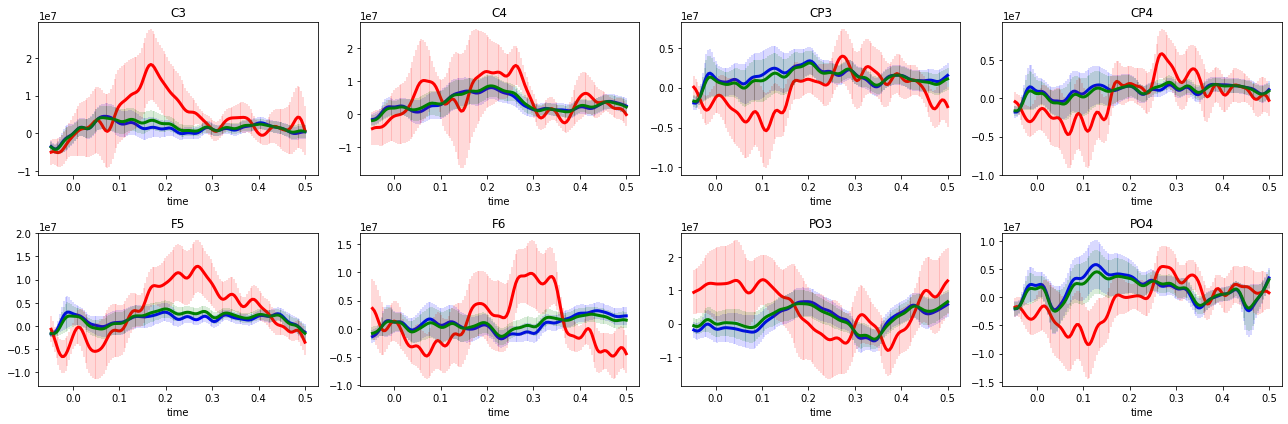

In [56]:
_,_,epochs,df_epochs,_,_ = simple_aob_ana("../explorer_datasets/auditory_oddball/fusionDataExport_1705700582/",thr=1E3, verbose=True, lfreq=1,ufreq=30,
                       standard_stim_str = './assets/sounds/1024hz.mp3', deviant_stim_str = './assets/sounds/1920hz.mp3',
                       doplot1=False,doplot2=False,doplot3=False,doplot4=False,doplot5=True,doplot6=False)

In [57]:
df_epochs

,chan,condition,CP3,C3,F5,PO3,PO4,F6,C4,CP4,stim
time,epoch,,,,,,,,,,
-0.199219,0,1,-3.681873e+06,-1.443120e+06,-1.199174e+06,-1.315325e+07,-3.874188e+06,1.684102e+07,9.315935e+06,2.122351e+04,0.0
-0.195312,0,1,-5.551581e+06,-4.302529e+06,-3.142492e+06,-1.613163e+07,-6.385347e+06,1.259932e+07,5.742701e+06,-1.618722e+06,0.0
-0.191406,0,1,-7.067921e+06,-7.567160e+06,-5.025694e+06,-1.819784e+07,-8.259537e+06,7.619298e+06,1.538510e+06,-3.564294e+06,0.0
-0.187500,0,1,-7.989797e+06,-1.035849e+07,-6.614293e+06,-1.876567e+07,-9.143044e+06,2.775547e+06,-2.370902e+06,-5.347769e+06,0.0
-0.183594,0,1,-8.326837e+06,-1.212133e+07,-7.935645e+06,-1.780142e+07,-9.070290e+06,-1.137548e+06,-5.287085e+06,-6.670671e+06,0.0
...,...,...,...,...,...,...,...,...,...,...,...
0.484375,178,2,-2.759369e+06,7.462519e+06,9.229774e+06,1.139717e+07,4.589709e+06,1.239826e+07,2.375669e+07,1.188599e+07,0.0
0.488281,178,2,-3.472636e+06,6.205271e+06,8.810745e+06,1.176432e+07,4.460961e+06,1.241219e+07,2.422584e+07,1.162107e+07,0.0
0.492188,178,2,-4.848553e+06,4.573010e+06,7.520811e+06,1.158470e+07,3.342393e+06,1.158042e+07,2.284189e+07,1.013429e+07,0.0


Creating RawArray with float64 data, n_channels=9, n_times=59632
    Range : 0 ... 59631 =      0.000 ...   232.934 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 30.00 Hz: -6.02, -6.02 dB

Not setting metadata
180 matching events found
Setting baseline interval to [-0.19921875, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 180 events and 180 original time points ...
0 bad epochs dropped


<ipython-input-42-cb96d4b4b5a5>:60: RuntimeWarning: invalid value encountered in cast
  events = events.astype(int)


orig # standards: 160
orig # deviants: 20
final # standards: 28800
final # deviants: 3600


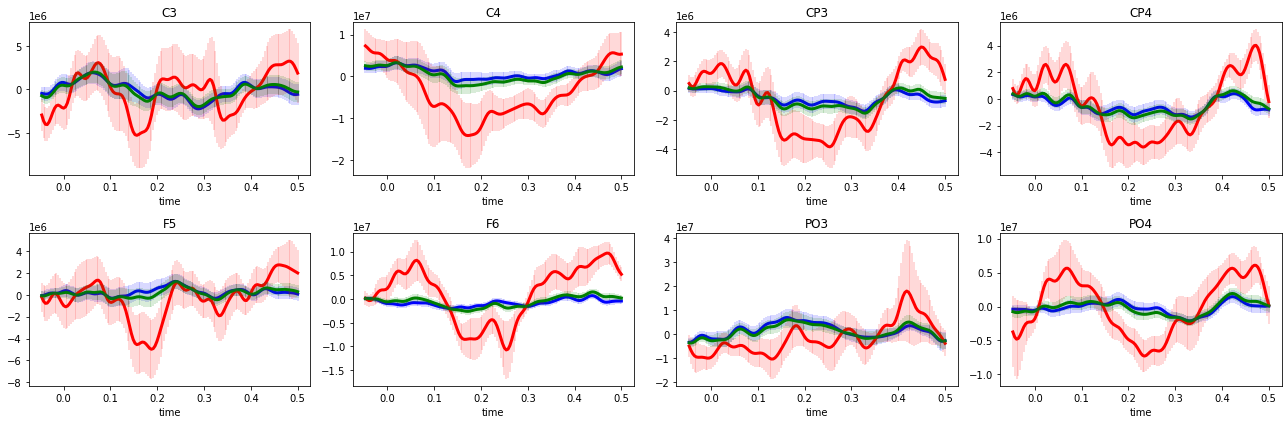

In [44]:
_ = simple_aob_ana("../explorer_datasets/auditory_oddball/fusionDataExport_1705701095/",thr=1E3, verbose=True, lfreq=1,ufreq=30,
                       standard_stim_str = './assets/sounds/1024hz.mp3', deviant_stim_str = './assets/sounds/1920hz.mp3',
                       doplot1=False,doplot2=False,doplot3=False,doplot4=False,doplot5=True,doplot6=False)